# Recommendations Engine — Movie Metadata and Reviews

Michael Richman <br/>
mike.d.richman@gmail.com <br/>
http://github.com/zgana

In this notebook, we build and test movie recommenders using movie metadata from IMDb, as well as the 100k IMDb movie reviews dataset and additional data acquired from Movie Lens.

**Contents:**

* [Tools](#Tools)
* [Dataset introduction](#Dataset-introduction)
* [Data load](#Data-load)
* [Data cleaning and merging](#Data-cleaning-and-merging)
* [Initial exploration](#Initial-exploration)
* [Similarity models](#Similarity-models)
* [Recommender — reviewed movies only](#Recommender-—-reviewed-movies-only)
* [MovieLens user data](#MovieLens-user-data)
* [Quantifying recommender performance](#Quantifying-recommender-performance)
* [Collaborative filtering](#Collaborative-filtering)
* [Conclusions](#Conclusions)

## Tools

In [1]:
# standard library
from collections import defaultdict, Counter
import datetime
import itertools
import os
import re
import string
import sys
import textwrap

# scientific stack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import sparse

# markup parsing
from bs4 import BeautifulSoup

# unicode simplification
from unidecode import unidecode

# TF-IDF word vector weighting
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# Personal histogram / kernel density estimate tool
# https://histlite.readthedocs.io/
import histlite as hl

%matplotlib inline

In [2]:
plt.rc('figure', dpi=100)

In [3]:
def prush(*a, **kw):
    """Print, and immediately flush for prompt progress updates."""
    print(*a, **kw)
    sys.stdout.flush()

In [4]:
def pfill(s, width=90):
    """Print string with text wrapping."""
    print(textwrap.fill(s, width=width))

## Dataset introduction

**Movie Metadata (IMDb)**

The primary dataset for this project comes directly from IMDb at

https://datasets.imdbws.com/.

Conditions for use of this dataset are laid out at https://www.imdb.com/conditions, and include a provision that commercial use requires licensing through their licensing department as described here: https://www.imdb.com/licensing/.


**Movie Reviews (IMDb)**

We will also make use of the 100k movie reviews dataset, accessed at

https://ai.stanford.edu/~amaas/data/sentiment/,

and first introduced in

https://www.aclweb.org/anthology/P11-1015.


**User Ratings (MovieLens)**

Finally, while this is not strictly required by the framing of the problem ("use IMDb data to build a recommendations engine"), it seems best to perform some sort of performance metrics on the system.  For this, we need ratings from specific users in order to test whether our recommendations are appropriate.  Such data does not appear to be readily available from IMDb, so instead we look to MovieLens.  There we find ~20M ratings by anonymized users, each of whom have rated at least 20 movies.

http://files.grouplens.org/datasets/movielens/ml-20m-README.html

## Data load

We begin by loading information about all titles in the dataset, including movies, TV shows, etc.

In [5]:
DATA_PATH = '/data/condor_builds/users/richman/data/'
# metadata
METADATA_PATH = os.path.join(DATA_PATH, 'imdb_metadata')
# reviews
REVIEW_PATH = os.path.join(DATA_PATH, 'aclImdb')
TRAIN_PATH = os.path.join(REVIEW_PATH, 'train')
TEST_PATH = os.path.join(REVIEW_PATH, 'test')
UNSUP_PATH = os.path.join(TRAIN_PATH, 'unsup')

In [6]:
def load_movie_data(table_name, index='tconst', index_to_int=True):
    """Load a data table, optionally setting the index."""
    out = pd.read_table(os.path.join(METADATA_PATH, f'{table_name}.tsv.gz'))
    if index:
        if index_to_int:
            out[index] = [int(i[2:]) for i in out[index]]
        out = out.set_index(index)
    return out

In [7]:
def clean_text(text):
    """Strip HTML tags with BeautifulSoup."""
    return BeautifulSoup(text, 'lxml').get_text()

In [8]:
def load_sup_dataset(path, max=np.inf):
    """Load pos/neg divided reviews from train or test dir."""
    texts = []
    ratings = []
    posnegs = []
    acl_indexs = []
    
    filename_pattern = re.compile(r'^(\d+)_(\d+).txt')
    for (i_sent, sent) in enumerate(['neg', 'pos']):
        prush(f'Reading {sent} ...')
        sent_path = os.path.join(path, sent)
        for (i, filename) in enumerate(sorted(os.listdir(sent_path))):
            if not i % 2000:
                prush(f'\r{i} ...', end='')
            m = filename_pattern.match(filename)
            acl_index, rating = int(m[1]), int(m[2])
            abs_filename = os.path.join(sent_path, filename)
            with open(abs_filename) as f:
                text = clean_text(f.read())
            texts.append(text)
            ratings.append(rating)
            posnegs.append(i_sent)
            acl_indexs.append(acl_index)
            if i >= max:
                break
        prush()
    # organize in dataframe; sort according to authors' indexing
    reviews = pd.DataFrame(dict(rating=ratings, pos=posnegs, text=texts, acl_index=acl_indexs))
    reviews.sort_values('acl_index', inplace=True)
    reviews = pd.concat((reviews[reviews.pos.values==0], reviews[reviews.pos.values==1]))
    return reviews

In [9]:
def load_unsup_dataset(path, max=np.inf):
    """Load reviews for unsupervised learning."""
    texts = []
    acl_indexs = []
    filename_pattern = re.compile(r'^(\d+)_\d+.txt')
    for (i, filename) in enumerate(sorted(os.listdir(path))):
        if not i % 10000:
            prush(f'\r{i} ...', end='')
        m = filename_pattern.match(filename)
        acl_index = int(m[1])
        abs_filename = os.path.join(path, filename)
        with open(abs_filename) as f:
            text = clean_text(f.read())
        texts.append(text)
        acl_indexs.append(acl_index)
        if i >= max:
            break
    prush()
    # organize in dataframe; sort according to authors' indexing
    reviews = pd.DataFrame(dict(text=np.array(texts), acl_index=np.array(acl_indexs)))
    reviews.sort_values('acl_index', inplace=True)
    return reviews

In [10]:
# kind, year, genre, etc.
basics = load_movie_data('title.basics')

/cvmfs/icecube.opensciencegrid.org/py3-v4.0.1/Ubuntu_18.04_x86_64/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [11]:
# ratings
ratings = load_movie_data('title.ratings')

In [12]:
# directors, writers
crew = load_movie_data('title.crew')

In [13]:
# people
people = load_movie_data('name.basics', index='nconst')

In [14]:
# name-id's of key individuals
principals = load_movie_data('title.principals')

We don't want TV shows, shorts, etc., and we'll err on the side of caution by immediately filtering out any "adult" entries:

In [15]:
wanted_titles = (basics.titleType == 'movie') & (basics.isAdult == 0)
movie_basics = basics[wanted_titles].drop(columns=['titleType', 'isAdult'])

We massage the `principals` data a bit in preparation for inclusion into the master table.

In [16]:
princ_dict = defaultdict(list)
prush('Parsing principals table...')
for (i, (tconst, nconst)) in enumerate(zip(principals.index, principals['nconst'].values)):
    if not i % 100_000:
        prush(f'\r{i:10d} ...', end='')
        sys.stdout.flush()
    if tconst in movie_basics.index:
        princ_dict[tconst].append(int(nconst[2:]))

Parsing principals table...
  35400000 ...

In [17]:
del principals

We'll also load up ALL of the available reviews.  I see no reason to withold any testing data here, since our metrics will be based on unrelated MovieLens data.

In [18]:
%time reviews_train = load_sup_dataset(TRAIN_PATH)

Reading neg ...
12000 ...
Reading pos ...
12000 ...
CPU times: user 14 s, sys: 1.6 s, total: 15.6 s
Wall time: 24 s


In [19]:
%time reviews_test = load_sup_dataset(TEST_PATH)

Reading neg ...
12000 ...
Reading pos ...
12000 ...
CPU times: user 13.8 s, sys: 1.62 s, total: 15.4 s
Wall time: 24.3 s


In [20]:
%time reviews_unsup = load_unsup_dataset(UNSUP_PATH)

40000 ...
CPU times: user 26.5 s, sys: 4.48 s, total: 31 s
Wall time: 48.5 s


That's just the reviews; next we parse their URLs in order to line them up with the correct movies.

In [21]:
def read_tconsts(filename):
    urls = np.genfromtxt(filename, dtype=str)
    regex_url = re.compile(r'.*tt(\d+)/.*')
    return np.array([int(re.sub(regex_url, r'\1', u)) for u in urls])
    
neg_tconst = read_tconsts(os.path.join(TRAIN_PATH, 'urls_neg.txt'))
pos_tconst = read_tconsts(os.path.join(TRAIN_PATH, 'urls_pos.txt'))
train_tconst = np.concatenate((neg_tconst, pos_tconst))

neg_tconst = read_tconsts(os.path.join(TEST_PATH, 'urls_neg.txt'))
pos_tconst = read_tconsts(os.path.join(TEST_PATH, 'urls_pos.txt'))
test_tconst = np.concatenate((neg_tconst, pos_tconst))

unsup_tconst = read_tconsts(os.path.join(TRAIN_PATH, 'urls_unsup.txt'))

In [22]:
all_texts = np.concatenate((
    reviews_unsup.text.values,
    reviews_train.text.values,
    reviews_test.text.values))
all_tconst = np.concatenate((
    unsup_tconst,
    train_tconst,
    test_tconst))

In [23]:
merged_reviews = defaultdict(str)
prush('Merging reviews per-movie...')
for (i, (tconst, text)) in enumerate(zip(all_tconst, all_texts)):
    if not i % 1000:
        prush(f'\r{i:5d} ...', end='')
    if tconst in movie_basics.index:
        merged_reviews[tconst] = ' ||| '.join([merged_reviews[tconst], text])

Merging reviews per-movie...
99000 ...

## Data cleaning and merging

We'll use some helper functions to reformat some of the data:

In [24]:
# two ways missing items are identified in the files
mNAs = r'\N', np.nan

def entries_cast(col, dtype=float, default=-1):
    """Convert entries to desired datatype (-1 for missing values)."""
    return [-1 if x in mNAs else dtype(x) for x in col.values]

def entries_split(col):
    """Split list-of-str entries."""
    return [[] if x in mNAs else x.split(',') for x in col.values]

def entries_split_ints(col):
    """Split list-of-str entries and convert to integer ids."""
    return [[] if x in mNAs else [int(xx[2:]) for xx in x.split(',')] for x in col.values]

regex_amp = re.compile(r'&')
regex_simplify = re.compile(r'[^\w\d -]')
regex_space = re.compile(r'[-\s]+')
def simplify_title(t):
    """Simplify titles for easier inspection."""
    t = unidecode(t).lower()
    t = re.sub(regex_amp, 'and', t)
    t = re.sub(regex_simplify, '', t)
    t = re.sub(regex_space, ' ', t)
    return t

Then we construct a master table, including basic metadata, ratings, and important personnel:

In [25]:
# join tables
prush('join...')
movies = movie_basics.join(crew).join(ratings)

# reformat some data
prush('runtime...')
movies['runtime'] = entries_cast(movies['runtimeMinutes'])
movies['year'] = entries_cast(movies['startYear'], dtype=int)
prush('genres...')
movies['genres'] = entries_split(movies['genres'])
prush('directors...')
movies['directors'] = entries_split_ints(movies['directors'])
prush('writers...')
movies['writers'] = entries_split_ints(movies['writers'])
prush('principals...')
movies['principals'] = [princ_dict[t] for t in movies.index]
# all people
prush('all people...')
movies['people'] = [
    np.unique(
        d + w + (p if isinstance(p,list) else [])
    )
    for (d,w,p)
    in zip(movies.directors.values, movies.writers.values, movies.principals.values)]

prush('reviews...')
movies['reviews'] = [merged_reviews[t] for t in movies.index]

prush('final odds and ends...')

#rename some data
movies.rename(columns={
    'primaryTitle': 'title',
    'averageRating': 'rating',
    'numVotes': 'nratings',
}, inplace=True)

# drop unwanted and already renamed columns
movies.drop(columns=['runtimeMinutes', 'originalTitle', 'startYear', 'endYear'], inplace=True)

# add "total love" column
movies['total_love'] = movies.rating * movies.nratings

# add simplified titles
movies['simple_title'] = [simplify_title(t) for t in movies.title.values]


join...
runtime...
genres...
directors...
writers...
principals...
all people...
reviews...
final odds and ends...


Occasionally we'll just want to grab random subsets of tables with this helper function:

In [26]:
def random_subset(movies, N=5, seed=None):
    random = np.random.RandomState(seed)
    return movies.iloc[np.random.randint(len(movies), size=N)]

We'll use this now to verify the structure of the master table of `movies`.

In [27]:
random_subset(movies)

,title,genres,directors,writers,rating,nratings,runtime,year,principals,people,reviews,total_love,simple_title
tconst,,,,,,,,,,,,,
888692,Facing Darkness,[Documentary],[489811],[],NaN,NaN,45.0,2006,"[489811, 2430635]","[489811, 2430635]",,NaN,facing darkness
312014,"Wesh wesh, qu'est-ce qui se passe?",[Drama],[1140699],"[1140699, 1175024]",6.9,192.0,83.0,2001,"[1184303, 1140699, 1177073, 1176968, 1176168, ...","[1125169, 1140699, 1174995, 1175024, 1176168, ...",,1324.8,wesh wesh quest ce qui se passe
1457765,The Haunting in Connecticut 2: Ghosts of Georgia,"[Drama, Horror, Mystery]",[253899],[1548597],5.3,15349.0,101.0,2013,"[506654, 817844, 614877, 755267, 3014840, 2538...","[112189, 253899, 506654, 614877, 631134, 75526...",,81349.7,the haunting in connecticut 2 ghosts of georgia
5723608,San gao zhuang,"[Drama, Musical]",[8144112],[508568],NaN,NaN,110.0,1962,"[719099, 492410, 1290989, 4117521, 8144112, 50...","[128748, 492410, 508568, 719099, 1290989, 4065...",,NaN,san gao zhuang
453399,Sleep When You're Dead,[Documentary],[1860080],"[1860080, 285249]",NaN,NaN,45.0,1990,"[1854614, 1860080, 2643138, 285249, 1857412, 1...","[285249, 1854614, 1857412, 1860080, 1860812, 2...",,NaN,sleep when youre dead


## Initial exploration

### Top movies

In [28]:
summary_cols = ['title', 'genres', 'rating', 'nratings', 'year']

The top of the list is pretty recognizable:

In [29]:
top_movies = movies.sort_values('total_love', ascending=False).head(1000)
top_movies.head(10)[summary_cols]

,title,genres,rating,nratings,year
tconst,,,,,
111161,The Shawshank Redemption,[Drama],9.3,2132513.0,1994
468569,The Dark Knight,"[Action, Crime, Drama]",9.0,2097252.0,2008
1375666,Inception,"[Action, Adventure, Sci-Fi]",8.8,1870220.0,2010
137523,Fight Club,[Drama],8.8,1704751.0,1999
110912,Pulp Fiction,"[Crime, Drama]",8.9,1673247.0,1994
109830,Forrest Gump,"[Drama, Romance]",8.8,1640894.0,1994
167260,The Lord of the Rings: The Return of the King,"[Adventure, Drama, Fantasy]",8.9,1516719.0,2003
120737,The Lord of the Rings: The Fellowship of the Ring,"[Adventure, Drama, Fantasy]",8.8,1532388.0,2001
68646,The Godfather,"[Crime, Drama]",9.2,1464201.0,1972


How likely are we to learn from the personnel info?  We check how often people repeat in this list:

In [30]:
counts = Counter(np.concatenate(top_movies.people.values))

In [31]:
print('max number of repeat appearances:', max(counts.values()))

max number of repeat appearances: 28


The distribution looks as follows:

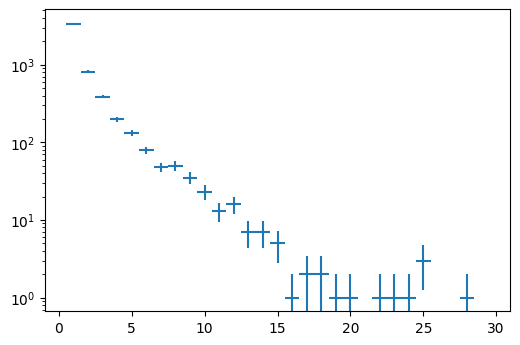

In [32]:
hl.plot1d(hl.hist(list(counts.values()), bins=np.r_[.5:30]), crosses=True)
plt.semilogy();

We can check out who are the stars:

In [33]:
name_id, appearances = np.array(list(counts.keys())), np.array(list(counts.values()))
order = np.argsort(appearances)[::-1]
stars = name_id[order[:5]]
people.iloc[np.in1d(people.index.values, stars)]

,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
nconst,,,,,
93,Brad Pitt,1963,\N,"actor,producer,soundtrack","tt0816711,tt0356910,tt0114746,tt1210166"
136,Johnny Depp,1963,\N,"actor,producer,soundtrack","tt0383574,tt0325980,tt0408236,tt0449088"
229,Steven Spielberg,1946,\N,"producer,writer,director","tt0108052,tt0082971,tt0120815,tt0083866"
456158,Jack Kirby,1917,1994,"writer,animation_department,miscellaneous","tt0371746,tt4154756,tt4154796,tt1825683"
498278,Stan Lee,1922,2018,"producer,writer,actor","tt3896198,tt2250912,tt1211837,tt1825683"


And then we repeat this for the entire dataset:

In [34]:
all_counts = Counter(np.concatenate(movies.people.values))
name_id, appearances = np.array(list(all_counts.keys())), np.array(list(all_counts.values()))
order = np.argsort(appearances)[::-1]
stars = name_id[order[:10]]
people.iloc[np.in1d(people.index.values, stars)]

,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
nconst,,,,,
636,William Shakespeare,1564,1616,"writer,soundtrack,miscellaneous","tt7344870,tt3894536,tt5932378,tt8632012"
6137,Ilaiyaraaja,1943,\N,"composer,music_department,soundtrack","tt0101649,tt0887769,tt0086231,tt5340516"
6982,Adoor Bhasi,1929,1990,"actor,director,music_department","tt0155472,tt0076277,tt0268954,tt0282889"
103977,Brahmanandam,1956,\N,"actor,music_department,soundtrack","tt3142764,tt1156516,tt5457772,tt1756476"
232490,Dong-Chun Hyeon,\N,\N,editor,"tt5240408,tt0334278,tt0333585,tt0308606"
305182,Eddie Garcia,1929,2019,"actor,director,soundtrack","tt2244376,tt0318412,tt0124988,tt0186511"
453459,Hui-su Kim,\N,\N,editor,"tt0350251,tt0333927,tt0406717,tt0352001"
473742,Laxmikant Shantaram Kudalkar,1937,1998,"composer,soundtrack,music_department","tt0146645,tt0061974,tt0338013,tt0214841"
648803,Matsunosuke Onoe,1875,1926,"actor,director,producer","tt1006821,tt1087637,tt0877604,tt1155764"


The distribution of [number of films an individual is involved with] is peaked at 1 but has a long tail:

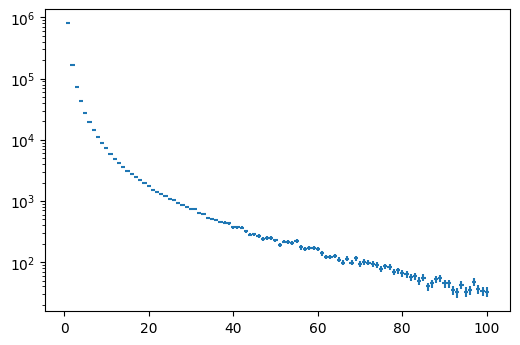

In [35]:
hl.plot1d(hl.hist(list(all_counts.values()), bins=np.r_[.5:101]), crosses=True)
plt.semilogy();

I didn't expect Shakespeare to rank so highly; let's see why:

In [36]:
includes_shakespeare = [636 in p for p in movies.people.values]
movies[includes_shakespeare].sort_values('total_love', ascending=False).head(10)[summary_cols]

,title,genres,rating,nratings,year
tconst,,,,,
147800,10 Things I Hate About You,"[Comedy, Drama, Romance]",7.3,273534.0,1999
117509,Romeo + Juliet,"[Drama, Romance]",6.7,197624.0,1996
89881,Ran,"[Action, Drama]",8.2,101143.0,1985
55614,West Side Story,"[Crime, Drama, Musical]",7.5,89076.0,1961
3390572,Haider,"[Action, Crime, Drama]",8.1,46550.0,2014
50613,Throne of Blood,"[Drama, History]",8.1,40430.0,1957
2884018,Macbeth,"[Drama, History, War]",6.6,49509.0,2015
102494,My Own Private Idaho,[Drama],7.1,45419.0,1991
49223,Forbidden Planet,"[Action, Adventure, Sci-Fi]",7.6,41860.0,1956


Oh right, people re-tell Shakespeare's stories in films all the time.  Moving on...

### Rating distribution

Rating information might be useful, but many values are missing.  Before deciding how to handle missing data, we should see how the ratings are distributed:

In [37]:
rated_movies = movies[np.isfinite(movies.rating)]

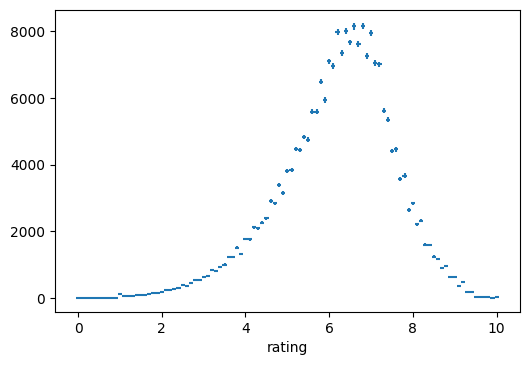

In [38]:
hl.plot1d(hl.hist(rated_movies.rating, bins=np.r_[-.05:10.1:.1]), crosses=True)
plt.xlabel('rating');

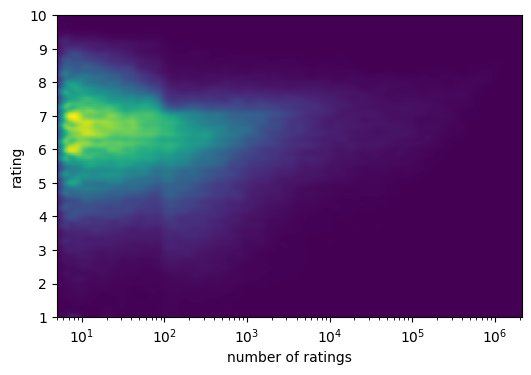

In [39]:
fig, ax = plt.subplots()
hl.plot2d(hl.kde((rated_movies.nratings, rated_movies.rating), log=(True, False)))
ax.set_xlabel(r'number of ratings')
ax.set_ylabel(r'rating');

There appears to be some sort of threshold at 100, but it's unclear so far what implications that may have.

### Genre distribution

In [40]:
genre_counts = Counter(np.concatenate(movies.genres.values))
k, v = np.array(list(genre_counts.keys())), np.array(list(genre_counts.values()))
o = np.argsort(v)
k, v = k[o], v[o]

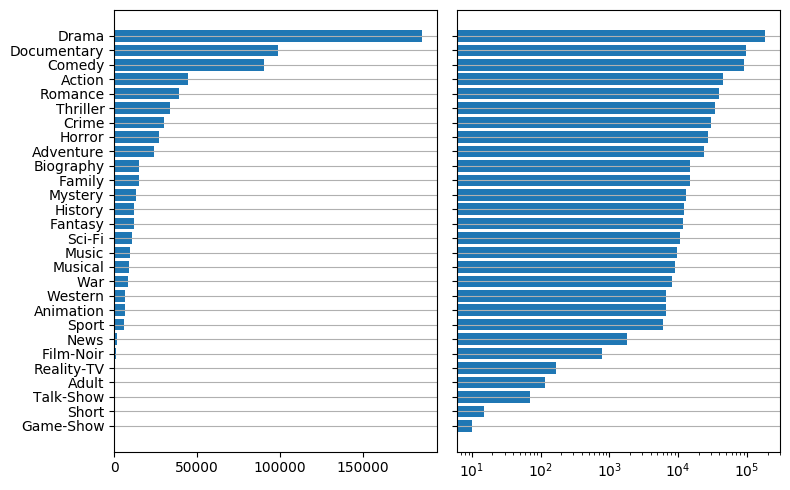

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
r = np.arange(len(v))
ax[0].barh(r, v)
plt.yticks(r, k)
ax[1].barh(r, v)
ax[1].semilogx()
for a in ax:
    a.grid(axis='y')
plt.tight_layout()

## Similarity models

Our strategy will be to model the similarity between different movies based on various available criteria.  We'll use the following four aspects of the data:

* **People involved in making each film:** if a user likes movies involving certain directors, writers, producers, etc. then it stands to reason that they may also like other work by those individuals.
* **Genre:** if a user enjoys dramas, we'll recommend more dramas.
* **Ratings:** if a user enjoys highly rated movies or very popular (often rated) movies, we'll recommend more movies that are similar on these axes.  (Alternative: un-personalized rating-based recommendations — this is actually the form we will use later.)
* **Review content:** if a user likes movies that tend to yield reviews containing certain words, we'll recommend more movies that generate similar reviews.

For the purposes of this in-notebook exercise, we'll implement similarity models using an interface inspired by, but not strictly conformant to, the sklearn interface.  "Fitting" will look mostly standard, but "predict" will be based on pre-cached vectors tied to `tconst` handles.  This will allow some caching to make things not _quite_ so slow when working with e.g. the entire movie list.

### PeopleSimilarity

In [42]:
class PeopleSimilarity(object):
    
    """Rank movies' similarity based on overlap of people who made them.
    
    This model can also consider people other than directors/writers/actors
    (e.g. who watched, who rated, who rated highly, etc.).
    """
    
    def __init__(self, column='people'):
        self.column = 'people'
    
    def fit(self, X, verbose=True):
        # count movies, save index
        movies = X
        column = self.column
        self.index = index = movies.index
        n_movies = len(index)

        # get people
        all_people = np.unique(np.concatenate(movies[column].values)).astype(int)
        max_person_id = all_people[-1] + 1

        if verbose:
            prush('Building feature arrays...')
        data, row, col = [], [], []
        for (i, people) in enumerate(movies[column].values):
            ones = np.ones(len(people), dtype=int)
            r = i * ones
            c = people
            data.extend(ones)
            row.extend(r)
            col.extend(c)

        if verbose:
            prush('Building sparse feature matrix...')

        movie_data_matrix = sparse.csr_matrix(
            (data, (row, col)),
            shape=(n_movies, max_person_id))

        if verbose:
            prush('Computing similarity matrix...')
        similarity = cosine_similarity(movie_data_matrix, movie_data_matrix, dense_output=False)
        
        # done; save info
        self.similarity = similarity
        
    def predict(self, x, densify=True):
        i = [self.index.get_loc(xx) for xx in np.atleast_1d(x)]
        out = self.similarity[i]
        if densify:
            out = out.toarray()
        out = out.mean(axis=0)
        return out

### GenreSimilarity

In [43]:
class GenreSimilarity(object):
    
    """Rank movies' similarity based on overlap of genres covered."""
    
    def __init__(self):
        pass
    
    def _to_int(self, genres):
        # assumes no hash collisions...
        return np.array([self.genres.index(g) for g in genres], dtype=int)
    
    def _to_row(self, genres):
        out = np.zeros(self.n_genres, dtype=int)
        out[self._to_int(genres)] = 1
        return out
    
    def fit(self, X):
        movies = X
        self.index = index = movies.index
        n_movies = len(index)
        self.genres = sorted(set(np.concatenate(movies.genres.values)))
        self.n_genres = len(self.genres)
        
        self.genre_matrix = np.array([self._to_row(g) for g in movies.genres.values])
        
    def predict(self, x):
        i = [self.index.get_loc(xx) for xx in np.atleast_1d(x)]
        similarity = cosine_similarity(self.genre_matrix[i], self.genre_matrix)
        return similarity.mean(axis=0)

### RatingSimilarity

In [44]:
class RatingSimilarity(object):
    
    """Rank movies' similarity based on value and number of ratings.
    
    This model can relate movies to each other, or simply to the origin (0,0).
    The latter yields a completely un-personalized popularity contest.
    """
    
    def __init__(self, popularity_only=False):
        self.popularity_only = popularity_only
    
    def _fill_mean(self, a):
        a = a.values
        mask = np.isfinite(a)
        mask[mask] &= a[mask] > -1
        return np.where(mask, a, np.mean(a[mask]))
    
    def _scale_array(self, a):
        a = a - a.min()
        a /= a.max()
        return a
    
    def fit(self, X):
        movies = X
        self.index = index = movies.index
                
        # could add options for how to deal with missing data
        rating = self._fill_mean(movies.rating)
        nratings = self._fill_mean(movies.nratings)
        a = self._scale_array(rating)
        b = self._scale_array(np.log10(nratings))
        
        self.numerics_matrix = np.transpose([a, b])
        self.popularity_vector = np.hypot(a, b)
        
    def predict(self, x):
        x = np.atleast_1d(x)
        if self.popularity_only:
            return np.mean([self.popularity_vector for xx in x], axis=0)
        else:
            i = [self.index.get_loc(xx) for xx in x]
            similarity = euclidean_distances(self.numerics_matrix[i], self.numerics_matrix)
            return similarity.mean(axis=0)

### ReviewSimilarity

In [45]:
# stop words borrowed from sentiment analysis notebook
stop_words = """
she very when more can some what if has out about or her there so from an who by they at
all one be have his are he on you film movie for with as was that this in it is to of and
the
"""

class ReviewSimilarity(object):
    
    """Rank movies' similarity based on words contained in reviews by users."""
    
    def __init__(self, max_features=10000):
        self.max_features = max_features
        
    def fit(self, X):
        # TODO: is it worth including bigrams? trigrams?
        movies = X
        self.index = movies.index
        self.vectorizer = TfidfVectorizer(
            ngram_range=(1,1),
            min_df=3,
            max_features=self.max_features,
            decode_error='replace',
            strip_accents='unicode')
        self.review_matrix = self.vectorizer.fit_transform(movies.reviews.values)
        
    def predict(self, x):
        i = [self.index.get_loc(xx) for xx in np.atleast_1d(x)]
        similarity = cosine_similarity(self.review_matrix[i], self.review_matrix)
        return similarity.mean(axis=0)

## Recommender — reviewed movies only

Now we finally come to the recommender engine itself.  Its task is to provide a convenient interface for obtaining the recommendations, either in an ad-hoc way or, as we'll see below, programmatically based on `tconst` values.

In [46]:
class Recommender(object):
    
    """Recommend movies based on similarity models."""

    def __init__(self, movies, models, weights=None):
        self.movies = movies
        models = np.atleast_1d(models)
        self.models = models
        if weights is None:
            weights = np.ones(len(self.models))
        self.weights = weights
        
    def _title_to_tconst(self, title, year=None):
        """Accept simple_title or tconst(s); return tconst(s)."""
        movies = self.movies
        if isinstance(title, str):
            cond = movies.simple_title.values == simplify_title(title)
            if not np.any(cond):
                raise ValueError(f'"{title}" not found in database')            
            if year is not None:
                cond *= movies.year.values == year
            tconst = movies.index.values[np.where(cond)[0][0]]
        else:
            tconst = title
        return tconst
        
    def get_recommendations(self, title, year=None, N=10, future=False):
        """Give descending-relevance tconsts and corresponding similarity measures."""
        # get similarity measures based on each model
        tconst = self._title_to_tconst(title, year)
        sims = np.array([model.predict(tconst) for model in self.models])
        # get weighted overall similarity
        sims = np.mean(sims.T * self.weights, axis=-1)
        # get N best, excluding items from the future by default
        sims_order = np.argsort(sims)[::-1][:3*N]
        df = self.movies.iloc[sims_order]
        tconsts, years = df.index.values, df.year.values
        if not future:
            tconsts = tconsts[years <= 2019]
        return tconsts[:N+1], sims[sims_order][:N+1]
        
    def print_recommendations(self, title, year=None, N=10, future=False):
        """Print a recommendations list."""
        tconsts, sims = self.get_recommendations(title, year=year, N=N, future=future)
        df = self.movies.loc[tconsts]
        titles = df.title.values
        years = df.year.values
        if len(np.atleast_1d(title)) == 1:
            header = f'Because you liked: {titles[0]}'
            if years[0] > -1:
                header += f' ({years[0]})'
            if future:
                header += ' (future included)'
            print(header)
        for (i, (title, year, sim, tconst)) in enumerate(zip(titles[1:], years[1:], sims[1:], tconsts[1:])):
            #line = f'{i+1:3d}: [{100*sim:3.0f}%] {title}'
            line = f'{i+1:3d}: {title}'
            if year > -1:
                line += f' ({year})'
            print(f'{line:60s}{tconst}')

Let's start with a recommender for reviewed movies only.

In [47]:
reviewed_movies = movies[movies.reviews.values != '']
print('{} movies are included in the reviews dataset.'.format(len(reviewed_movies)))

9611 movies are included in the reviews dataset.


In [48]:
top_reviewed_movies = reviewed_movies.sort_values('total_love', ascending=False).iloc[:1000]

In [49]:
top_reviewed_movies.head(10)[summary_cols]

,title,genres,rating,nratings,year
tconst,,,,,
109830,Forrest Gump,"[Drama, Romance]",8.8,1640894.0,1994
167260,The Lord of the Rings: The Return of the King,"[Adventure, Drama, Fantasy]",8.9,1516719.0,2003
120737,The Lord of the Rings: The Fellowship of the Ring,"[Adventure, Drama, Fantasy]",8.8,1532388.0,2001
114369,Se7en,"[Crime, Drama, Mystery]",8.6,1310318.0,1995
108052,Schindler's List,"[Biography, Drama, History]",8.9,1106848.0,1993
361748,Inglourious Basterds,"[Adventure, Drama, War]",8.3,1146680.0,2009
407887,The Departed,"[Crime, Drama, Thriller]",8.5,1092078.0,2006
482571,The Prestige,"[Drama, Mystery, Sci-Fi]",8.5,1082710.0,2006
499549,Avatar,"[Action, Adventure, Fantasy]",7.8,1057642.0,2009


We'll fit several similarity models:

In [50]:
models_reviewed = {}
models_reviewed['people'] = PeopleSimilarity()
models_reviewed['genre'] = GenreSimilarity()
models_reviewed['popularity'] = RatingSimilarity(popularity_only=True)
models_reviewed['reviews'] = ReviewSimilarity()

for (label, model) in models_reviewed.items():
    prush(f'== Fitting {label} ===')
    model.fit(reviewed_movies)

== Fitting people ===
Building feature arrays...
Building sparse feature matrix...
Computing similarity matrix...
== Fitting genre ===
== Fitting popularity ===
== Fitting reviews ===


And now we're ready to set up the `Recommender`:

In [51]:
models = [
    models_reviewed['people'],
    models_reviewed['genre'],
    models_reviewed['popularity'],
    models_reviewed['reviews']
]

weights = [.2, .15, .15, .5]

R = Recommender(reviewed_movies, models, weights)

Let's pick some random movies for which to inspect the results:

In [52]:
m = random_subset(reviewed_movies, seed=1)
m[summary_cols]

,title,genres,rating,nratings,year
tconst,,,,,
380726,Stara basn. Kiedy slonce bylo bogiem,"[Adventure, Drama, History]",5.4,1095.0,2003
473356,The Flock,"[Crime, Drama, Mystery]",5.7,10664.0,2007
68416,What Have You Done to Solange?,"[Horror, Mystery, Thriller]",7.0,3883.0,1972
72195,Space Is the Place,"[Music, Sci-Fi]",6.5,799.0,1974
879843,Katyn,"[Drama, History, War]",7.0,14534.0,2007


In [53]:
for tconst in m.index:
    R.print_recommendations(tconst)
    print()

Because you liked: Stara basn. Kiedy slonce bylo bogiem (2003)
  1: Katyn (2007)                                           879843
  2: Twin Falls Idaho (1999)                                162830
  3: Cold Mountain (2003)                                   159365
  4: Inglourious Basterds (2009)                            361748
  5: Boys Don't Cry (2000)                                  238119
  6: Who's Singin' Over There? (1980)                       76276
  7: The Lord of the Rings: The Return of the King (2003)   167260
  8: Landscape After Battle (1970)                          65948
  9: Danton (1983)                                          83789
 10: Troy (2004)                                            332452

Because you liked: The Flock (2007)
  1: Se7en (1995)                                           114369
  2: Disturbia (2007)                                       486822
  3: The Jackal (1997)                                      119395
  4: Frequency (2000)           

These seem mostly plausible to me based on what little I know or can quickly learn about the movies, but... ok, let's instead try some moderately but not extremely popular movies:

In [54]:
m = top_reviewed_movies.iloc[:500][-5:]
m[summary_cols]

,title,genres,rating,nratings,year
tconst,,,,,
338095,High Tension,[Horror],6.8,63617.0,2003
87803,1984,"[Drama, Sci-Fi]",7.1,60848.0,1984
841046,Walk Hard: The Dewey Cox Story,"[Comedy, Music]",6.8,63218.0,2007
120731,The Legend of 1900,"[Drama, Music, Romance]",8.1,53010.0,1998
462465,Outlander,"[Action, Adventure, Fantasy]",6.2,69226.0,2008


In [55]:
for tconst in m.index:
    R.print_recommendations(tconst)
    print()

Because you liked: High Tension (2003)
  1: The Texas Chain Saw Massacre (1974)                    72271
  2: Hostel (2005)                                          450278
  3: Saw (2004)                                             387564
  4: The Ruins (2008)                                       963794
  5: Cabin Fever (2002)                                     303816
  6: Night of the Living Dead (1990)                        100258
  7: House of 1000 Corpses (2003)                           251736
  8: Unhinged (1982)                                        180274
  9: Three... Extremes (2004)                               420251
 10: The Shining (1980)                                     81505

Because you liked: 1984 (1984)
  1: The Prestige (2006)                                    482571
  2: A Clockwork Orange (1971)                              66921
  3: K-PAX (2001)                                           272152
  4: Close Encounters of the Third Kind (1977)              7

Here are the IMDb blurbs, manually pulled from IMDb, for these last 5 "because you liked" attempts:

**High Tension (2003):** Best friends Marie and Alexia decide to spend a quiet weekend at Alexia's parents' secluded farmhouse. But on the night of their arrival, the girls' idyllic getaway turns into an endless night of horror. 

**1984 (1984):**  In a totalitarian future society, a man, whose daily work is re-writing history, tries to rebel by falling in love.

**Walk Hard: The Dewey Cox Story (2007):** Singer Dewey Cox overcomes adversity to become a musical legend.  (We actually match with IMDb's recommendations of Step Brothers, Tenacious D and the Pick of Destiny, and The 40-Year-Old Virgin.)

**The Legend of 1900 (1998):** A baby boy, discovered in 1900 on an ocean liner, grows into a musical prodigy, never setting foot on land.

**Outlander (2008):** During the reign of the Vikings, Kainan, a man from a far-off world, crash lands on Earth, bringing with him an alien predator known as the Moorwen. Though both man and monster are seeking revenge for violence committed against them, Kainan leads the alliance to kill the Moorwen by fusing his advanced technology with the Viking's Iron Age weaponry.

The recommender is definitely picking up on _something_.  While there may still be some eyebrow-raisers in the lists, there are clear thematic similarities between the input movie and many of the recommendations.  We can see how horror, dystopia, and adult silliness are recognized and exploited in the recommendations.

We've weighted the recommender rather arbitrarily.  In a production setting, we would very obviously want to use information from users' past, and collect feedback as users interact with the system, in order to tune the weights as well as to include collaborative filtering and likely many additional models and heuristics.

So far, we haven't looked at any user data at all.  Let's give that a shot.

## MovieLens user data

In order to make some quantitative statements about the performance of various possible recommendation strategies, we turn to data from MovieLens:

In [56]:
ML20M_PATH = os.path.join(DATA_PATH, 'ml-20m')
ml20m_ratings = pd.read_csv(os.path.join(ML20M_PATH, 'ratings.csv'))
ml20m_links = pd.read_csv(os.path.join(ML20M_PATH, 'links.csv')).set_index('movieId')
ml20m_links.rename(columns={'imdbId': 'imdb'}, inplace=True)
ml20m_links.drop(columns=['tmdbId'], inplace=True)

We'll load it up, and restrict the dataset to those covered by the IMDb metadata.  We'll also exclude the most popular movies, since we are trying to personalize here.

In [57]:
ml20m = ml20m_ratings.join(ml20m_links, on='movieId')
ml20m = ml20m.loc[np.in1d(ml20m.imdb.values, movies.index.values)]
ml20m = ml20m.loc[~np.in1d(ml20m.imdb, top_movies.iloc[:50].index.values)]
ml20m.head(3)

,userId,movieId,rating,timestamp,imdb
0,1,2,3.5,1112486027,113497
1,1,29,3.5,1112484676,112682
2,1,32,3.5,1112484819,114746


The ratings in this dataset are distributed as follows:

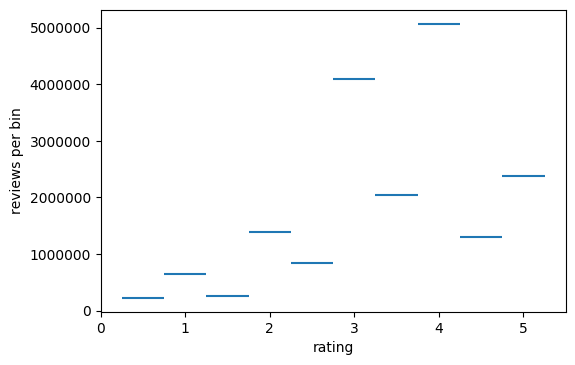

In [58]:
hl.plot1d(hl.hist(ml20m.rating, bins=np.r_[.25:5.26:.5]), crosses=True)
plt.xlabel(r'rating')
plt.ylabel(r'reviews per bin');

There are (too small to see) $\sqrt{N}$ errorbars on this plot!  So we can conclude with high confidence that the most likely rating is 4 ("it was good but it wasn't _perfect_") and that MovieLens users in general are generally disinclined to assign integer+plus+half ratings.

Next, we gather ratings by each individual user:

In [59]:
# i bet there's a fancy pandas trick for this
user_change_idx = np.r_[0, np.where(np.diff(ml20m.userId.values))[0] + 1]
user_movies = np.array([
    ml20m.movieId.values[i1:i2]
    for (i1, i2) in zip(user_change_idx[:-1], user_change_idx[1:])
])
user_ratings = np.array([
    ml20m.rating.values[i1:i2]
    for (i1, i2) in zip(user_change_idx[:-1], user_change_idx[1:])
])
user_nratings = np.array([len(r) for r in user_ratings])

That's sufficiently intense indexing work to warrant at least a spot check:

In [60]:
print('User 0')
print(user_movies[0])
print(user_ratings[0])
print('User 1')
print(user_movies[1])
print(user_ratings[1])

User 0
[    2    29    32   112   151   223   253   337   367   541   653   919
   924  1009  1036  1079  1080  1089  1090  1097  1136  1198  1200  1201
  1208  1214  1215  1217  1219  1222  1240  1243  1246  1249  1258  1259
  1261  1262  1266  1278  1291  1304  1321  1333  1348  1350  1358  1370
  1374  1387  1525  1584  1750  1848  1920  1967  1994  1997  2021  2100
  2118  2138  2140  2143  2173  2174  2193  2194  2253  2288  2291  2542
  2628  2644  2648  2664  2683  2692  2716  2761  2762  2804  2872  2918
  2944  2947  2968  3000  3030  3037  3081  3153  3265  3438  3476  3479
  3489  3499  3889  3932  3996  3997  4011  4027  4105  4128  4133  4306
  4446  4467  4571  4720  4754  4878  4896  4911  4915  4941  4980  5026
  5039  5040  5146  5171  5540  5679  5797  5816  5898  5999  6093  6242
  6333  6502  6754  6755  6774  6807  6834  6888  7001  7045  7046  7164
  7247  7387  7389  7438  7449  7454  7482  7757  8368  8482  8507  8636
  8690  8961 31696]
[3.5 3.5 3.5 3.5 4.  4. 

When this kind of indexing is wrong, weird out-of-order indices show up at the boundaries.

Unsurprisingly, a small number of ratings per user is most common, but there is a long tail towards very large numbers of ratings:

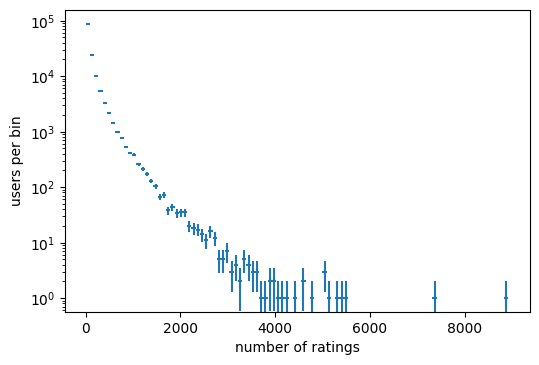

In [61]:
hl.plot1d(hl.hist(user_nratings, bins=100), crosses=True)
plt.semilogy()
plt.xlabel('number of ratings')
plt.ylabel('users per bin');

Let's check how individual users' ratings are distributed:

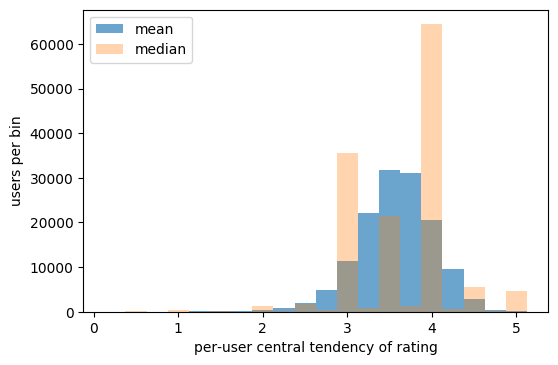

In [62]:
ml_rating_bins = np.r_[.125:5.26:.25]
# having seen that errorbars are miniscule here, we revert to ordinary matplotlib hists
plt.hist(list(map(np.mean, user_ratings)), bins=ml_rating_bins, label='mean', alpha=.66)
plt.hist(list(map(np.median, user_ratings)), bins=ml_rating_bins, label='median', alpha=.33)
plt.xlabel('per-user central tendency of rating')
plt.ylabel('users per bin')
plt.legend(loc='best');

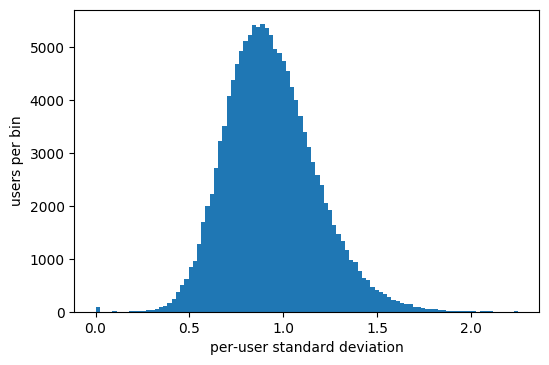

In [63]:
plt.hist(list(map(np.std, user_ratings)), bins=100)
plt.xlabel(r'per-user standard deviation')
plt.ylabel(r'users per bin');

Do MovieLens users' ratings correlate with IMDb's?

In [64]:
# i bet there's a fancy pandas trick for this too
ml20m_sortby_imdb = ml20m.sort_values('imdb')

movie_change_idx = np.r_[
    0,
    np.where(np.diff(ml20m_sortby_imdb.imdb.values))[0] + 1,
    len(ml20m_sortby_imdb)
]
ml_rating = np.array([
    np.mean(ml20m_sortby_imdb.rating.values[i1:i2])
    for (i1, i2) in zip(movie_change_idx[:-1], movie_change_idx[1:])
])

tconst_in_both = np.unique(ml20m.imdb)
imdb_rating = movies.loc[tconst_in_both].rating.values

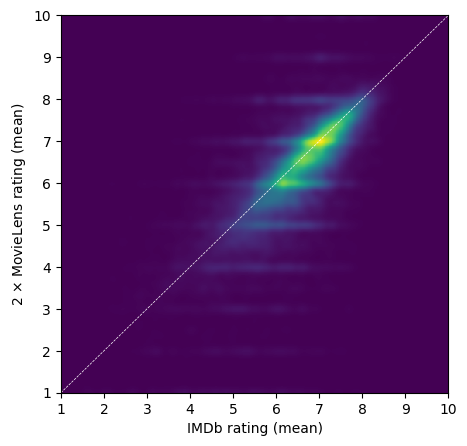

In [65]:
fig, ax = plt.subplots(figsize=(5,5))
mask = np.isfinite(imdb_rating * ml_rating)
h = hl.kde((imdb_rating[mask], 2*ml_rating[mask]), range=(1,10))
hl.plot2d(h)
ax.set_xlabel('IMDb rating (mean)')
ax.set_ylabel(r'2 $\times$ MovieLens rating (mean)')
ax.plot([1, 10], [1, 10], 'w--', lw=.5);

## Quantifying recommender performance

We need an operational definition for what it means for a user to like a movie.  The rating distributions are fairly tight, so this is tricky.  For now let's try "a user rates a movie higher than their own mean rating".

In [66]:
user_movies_liked = np.array([
    m[r > r.mean()]
    for (m, r) in zip(user_movies, user_ratings)
])

For testing, we'll consider a subset of users who rated around 300 movies (this gives us a decent compute time / statistics tradeoff given single-thread operation and code that hasn't been deliberately optimized for speed).

In [67]:
considered_user_index = np.where((295 <= user_nratings) & (user_nratings <= 305))[0]
considered_user_index.size

723

We'll take our performance metric to be MAP@k.  A reference implementation is found in this [ml_metrics](https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py) package; it looks like so:

In [68]:
def apk(actual, predicted, k=10):
    """Compute the average precision at k.
    
    From: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual.size:
        return 0.0

    return score / min(len(actual), k)

This helper function will get the recommendation list and evaluate AP@k for a given user's list of likes:

In [69]:
def get_user_apk(recommender, user_likes, k=100):
    """Predict based on even elements, test AP@k on odd elements."""
    imdb_user_likes = ml20m_links.loc[user_likes].imdb.values
    predicted = recommender.get_recommendations(imdb_user_likes[::2], N=k)[0]
    actual = imdb_user_likes[1::2]
    return apk(actual, predicted, k=k)

We'll define a set of similarity models that only recommend movies "liked" by _at least one user_:

In [70]:
all_liked_tconst = ml20m_links.loc[np.unique(np.concatenate(user_movies_liked))].imdb.values
liked_movies = movies.loc[all_liked_tconst]

models = models_liked = {}
models['people'] = PeopleSimilarity()
models['genre'] = GenreSimilarity()
models['popularity'] = RatingSimilarity(popularity_only=True)
models['reviews'] = ReviewSimilarity() # can only help for movies that were reviewed

for (label, model) in models.items():
    prush(f'== Fitting {label} ===')
    model.fit(liked_movies)

== Fitting people ===
Building feature arrays...
Building sparse feature matrix...
Computing similarity matrix...
== Fitting genre ===
== Fitting popularity ===
== Fitting reviews ===


... and we'll set up some recommenders, once again with arbitrary per-similarity-model weights:

In [71]:
models = models_liked

# not shown: hand-tuning weights
# like brute force but less reliable...
# also, note: specified weights need not sum to 1
recommenders = {
    'popularity': Recommender(
        liked_movies, models['popularity']),
    'popularity_people_genre': Recommender(
        liked_movies, [models['people'], models['genre'], models['popularity']],
        [.25, .05, .7]),
    'popularity_people_review_genre': Recommender(
        liked_movies, [models['people'], models['reviews'], models['genre'], models['popularity']],
        [.25, .25, .05, .7]),
}

Finally, we run a performance comparison based on these recommender variants:

In [72]:
now = datetime.datetime.now
t0 = now()
user_apks = {k: [] for k in recommenders}
for key in recommenders:
    prush('Recommender: "{}"'.format(key))
    for (ii,i) in enumerate(considered_user_index):
        if not ii % 25:
            prush(f'\r{ii:5d} ...', end='')
        user_likes = user_movies_liked[i]
        user_apks[key].append(get_user_apk(recommenders[key], user_likes))
    user_apks[key] = np.array(user_apks[key])
    prush(f'\r{ii:5d} ...')
print('end scoring: {} elapsed'.format(now() - t0))

Recommender: "popularity"
  722 ...
Recommender: "popularity_people_genre"
  722 ...
Recommender: "popularity_people_review_genre"
  722 ...
end scoring: 0:03:03.769233 elapsed


In [73]:
### @k=100, most popular 50 movies removed, only "likeable" movies included
for (k,v) in user_apks.items():
    print(f'{k:>50s}: {100*np.mean(v):7.4f} %  (mean)')
print()
for (k,v) in user_apks.items():
    print(f'{k:>50s}: {100*np.median(v):7.4f} %  (median)')

                                        popularity:  2.5021 %  (mean)
                           popularity_people_genre:  2.5470 %  (mean)
                    popularity_people_review_genre:  2.5747 %  (mean)

                                        popularity:  1.8266 %  (median)
                           popularity_people_genre:  1.9734 %  (median)
                    popularity_people_review_genre:  2.0641 %  (median)


I'm not personally accustomed to looking at such small values for precision, but it is encouraging that even without taking care to optimize the per-similarity-model weights, we find consistent improvements by adding info about people/genre/reviews for both `mean` and `median` benchmarks.  The percent improvement is:

In [74]:
v0 = np.mean(user_apks['popularity'])
for (k,v) in user_apks.items():
    if k == 'popularity':
        continue
    krat = f'{k} / popularity-only'
    print(f'{krat:>50s}: +{100*np.mean(v)/v0-100:7.4f} %  (mean)')
print()
v0 = np.median(user_apks['popularity'])
for (k,v) in user_apks.items():
    if k == 'popularity':
        continue
    krat = f'{k} / popularity-only'
    print(f'{krat:>50s}: +{100*np.median(v)/v0-100:7.4f} %  (median)')

         popularity_people_genre / popularity-only: + 1.7929 %  (mean)
  popularity_people_review_genre / popularity-only: + 2.9002 %  (mean)

         popularity_people_genre / popularity-only: + 8.0380 %  (median)
  popularity_people_review_genre / popularity-only: +13.0061 %  (median)


## Collaborative filtering

We originally set out to use the MovieLens dataset to quantify the performance of IMDb-data-based recommenders.  However, we now have lots of information about who likes what; we owe it to ourselves to see whether this can be used to produce recommendations.

First, we take note of who liked which movies:

In [75]:
liked_tconsts = defaultdict(list)
prush('Checking who liked what...')
for (i_user, user_likes) in enumerate(user_movies_liked):
    if not i_user % 10000:
        prush(f'\r{i_user} ...', end='')
    tconsts = ml20m_links.loc[user_likes].imdb.values
    for tconst in tconsts:
        liked_tconsts[tconst].append(i_user)
prush(f'\r{i_user} ...')

Checking who liked what...
138491 ...


In [76]:
liked_movies['liked_by'] = [liked_tconsts[tconst] for tconst in liked_movies.index.values]

We model this with a new `PeopleSimilarity` model, customized to examine the 'liked_by' column.

In [77]:
model_liked_by = PeopleSimilarity(column='liked_by')
model_liked_by.fit(liked_movies)

Building feature arrays...
Building sparse feature matrix...
Computing similarity matrix...


Here's a recommender similar to the above, but emphasizing community correlations over specific actors (and discarding the relatively sparse movie review data):

In [78]:
RR = Recommender(
    liked_movies,
    [model_liked_by, models['people'], models['genre'], models['popularity']],
        [.25, .1, .05, .6])

The most popular movies that satisfy our "liked" criteria are:

In [79]:
liked_movies.sort_values('total_love', ascending=False).head()[summary_cols + ['liked_by']]

,title,genres,rating,nratings,year,liked_by
tconst,,,,,,
1049413,Up,"[Adventure, Animation, Comedy]",8.2,859985.0,2009,"[81, 95, 128, 130, 132, 135, 207, 208, 212, 23..."
105236,Reservoir Dogs,"[Crime, Drama, Thriller]",8.3,842826.0,1992,"[2, 20, 21, 22, 23, 34, 47, 50, 53, 55, 57, 60..."
371746,Iron Man,"[Action, Adventure, Sci-Fi]",7.9,879242.0,2008,"[10, 30, 95, 106, 132, 135, 161, 162, 197, 238..."
338013,Eternal Sunshine of the Spotless Mind,"[Drama, Romance, Sci-Fi]",8.3,836400.0,2004,"[10, 17, 34, 41, 49, 57, 60, 64, 90, 95, 98, 1..."
82971,Raiders of the Lost Ark,"[Action, Adventure]",8.4,824166.0,1981,"[0, 2, 4, 9, 10, 41, 42, 43, 47, 48, 50, 53, 5..."


Of these, my personal favorite is _Eternal Sunshine of the Spotless Mind_, so let's see what else I might like:

In [80]:
RR.print_recommendations('eternal sunshine of the spotless mind')

Because you liked: Eternal Sunshine of the Spotless Mind (2004)
  1: The Truman Show (1998)                                 120382
  2: 12 Angry Men (1957)                                    50083
  3: Good Will Hunting (1997)                               119217
  4: Life Is Beautiful (1997)                               118799
  5: A Clockwork Orange (1971)                              66921
  6: City of God (2002)                                     317248
  7: The Shining (1980)                                     81505
  8: Casablanca (1942)                                      34583
  9: Requiem for a Dream (2000)                             180093
 10: Slumdog Millionaire (2008)                             1010048


This seems promising.  Let's add it to the basket and repeat the MAP@k test:

In [81]:
recommenders_inc_collab = {}
recommenders_inc_collab.update(recommenders)
recommenders_inc_collab['users_popularity_people_genre'] = RR

In [82]:
now = datetime.datetime.now
t0 = now()
uapks = user_apks_inc_collab = {}
uapks.update(user_apks)
recs = recommenders_inc_collab
for key in recs:
    if key in user_apks_inc_collab:
        continue
    else:
        user_apks_inc_collab[key] = []
    prush('Recommender: "{}"'.format(key))
    for (ii,i) in enumerate(considered_user_index):
        if not ii % 25:
            prush(f'\r{ii:5d} ...', end='')
        user_likes = user_movies_liked[i]
        uapks[key].append(get_user_apk(recs[key], user_likes))
    uapks[key] = np.array(uapks[key])
    prush(f'\r{ii:5d} ...')
print('end scoring: {} elapsed'.format(now() - t0))

Recommender: "users_popularity_people_genre"
  722 ...
end scoring: 0:00:16.302124 elapsed


In [83]:
### @k=100, most popular 50 movies removed, only "likeable" movies included
uapks = user_apks_inc_collab
for (k,v) in uapks.items():
    print(f'{k:>50s}: {100*np.mean(v):7.4f} %  (mean)')
print()
for (k,v) in uapks.items():
    print(f'{k:>50s}: {100*np.median(v):7.4f} %  (median)')

                                        popularity:  2.5021 %  (mean)
                           popularity_people_genre:  2.5470 %  (mean)
                    popularity_people_review_genre:  2.5747 %  (mean)
                     users_popularity_people_genre:  2.5407 %  (mean)

                                        popularity:  1.8266 %  (median)
                           popularity_people_genre:  1.9734 %  (median)
                    popularity_people_review_genre:  2.0641 %  (median)
                     users_popularity_people_genre:  2.0154 %  (median)


Well, even with the best weighting I've been able to find so far by hand, it seems it's still (arguably) better to use review information than "other users liked", as formulated here.  Still, it is good to see that at least for median, if not mean AP@k, including "other users liked" does seem like it might be adding useable information.

## Conclusions

We've seen that we can come up with plausibly good movie recommendations based on criteria such as:

* Who made it?
* What genre(s) are covered?
* What words are used in the reviews?
* How popular is it?
* Who else liked it?

In particular, we've shown that even in a test that seems to favor "just show me whatever is popular", we can improve with customization based on other information.

We've quantified performance using MAP@k, which strongly rewards not just identifying some additional liked/likeable items, but ranking such items highly.  In an environment where that is what we care about and the metric is appropriate, it would be worth digging into what results in false positives receiving high rankings and studying how to reject them.

There are virtually endless ways to extend this work.  There's a reason Netflix offered a large prize to anyone who could make even a modest improvement to their recommendation algorithm!  Of course, there's also a reason that they only partially implemented winning ideas — mainly complexity and computational performance, if I understand correctly.

In a production system, many improvements would be both possible and desireable.  Perhaps the most obvious is that ideally we would analyze plot synopses instead of, or in addition to, reviews.

We would also be very interested in more fine-grained user data.  Rating scales give noisy feedback because we don't all read them the same way.  They also introduce bias because we aren't all equally likely to volunteer ratings.  If we were in control of the system (as are cable companies, Netflix, YouTube, etc.) then we could give recommendations and then constantly measure the resulting user behavior (number of clicks, time spent following up on recommendations, etc.).

More sophisticated — and computationally performant — methods would be required to handle so much data.  One way to start would be to perform clustering analysis in the various relevant high-dimensional vector spaces.  Then recommendations would proceed only within relevant clusters.  Recommendations from each cluster could be computed in parallel and then merged based on overall relevance ranking.  This sort of pre-clustering would also naturally accomodate more complex user profiles, as opposed to the simple approach taken here of simply averaging over all known-liked item vectors on a per-criterion (people/genre/reviews/etc.) basis.  Of course, it would also be also possible to treat each criterion in parallel.

With or without additional user feedback, a crucial question remains: how can we really tell whether a user liked something?  Is there even a single optimal definition?  Furthermore, here we've only considered M (mean or median) AP@k, but other metrics (e.g. DCG: discounted cumulative gain) can be used.  It may be that the best results would be obtained by considering a whole spectrum of operational definitions for both recommendation relevance and performance metric.

For me personally, this is my first experience with implementing recommendations.  I intend to try using it for its nominally intended purpose.  One feature available in a home-grown solution like this is that I can explicitly decide how much weight to give to aspects such as popularity, cast, genre, topics covered, and probability that "people like me" also like something.  I wish more online tools would allow users to opt into such customization!  